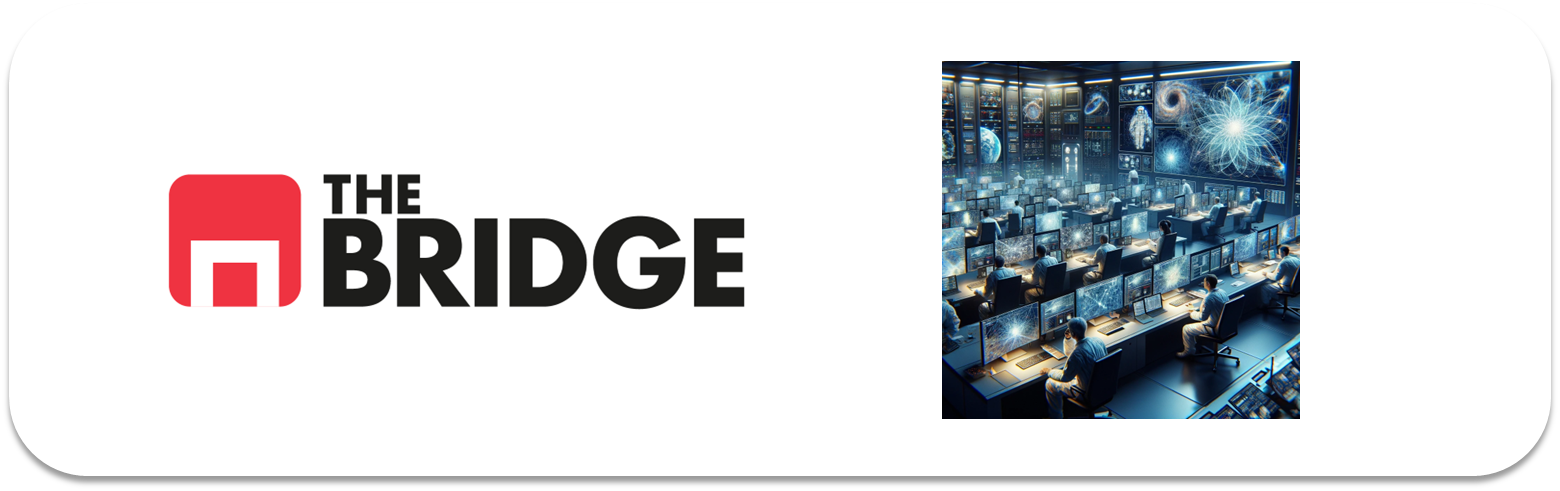

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.utils import shuffle

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from tensorflow.keras import Model
import pandas as pd
# ignore warnings
#import warnings
#warnings.filterwarnings("ignore")

### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



In [14]:
# Vamos a importar las fotos

import zipfile
path_to_zip_file = "./data/seg_test.zip"
directory_to_extract_to = "./data/"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [15]:
path_to_zip_file = "./data/seg_train.zip"
directory_to_extract_to = "./data/"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [16]:
# Creamos los datasets

ROOT_PATH = './data/'
TRAIN_PATH = ROOT_PATH + "seg_train/"
TEST_PATH = ROOT_PATH + "seg_test/"

def read_data(directorio, reshape_dim = (32,32)):
    X = []
    y = []
    for folder in os.listdir(directorio):
        print(folder)
        if os.path.isdir('/'.join([directorio, folder])):
            for file in os.listdir('/'.join([directorio, folder])):

                image = plt.imread('/'.join([directorio, folder, file]))
                image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32

                X.append(image)
                y.append(folder)

    return np.array(X),np.array(y)

In [17]:
X_train,y_train = read_data(TRAIN_PATH)
X_test, y_test = read_data(TEST_PATH) 

buildings
forest
glacier
mountain
sea
street
buildings
forest
glacier
mountain
sea
street


In [18]:
# Veamos la pinta que tiene
X_train.shape

(14034, 32, 32, 3)

In [19]:
# Son fotografías de 32x32 con 3 canales a color. Hay un total de 14034.


In [20]:
# Vamos a intentar, como dice el enunciado usar primero un ResNetV50
# Tal como exige ese formato habrá que hacer un resize a 224x224

# Cargamos los datos de test
X_test_224 = []
y_test_224 = []

for category in os.listdir(TEST_PATH):
    for file in os.listdir(os.path.join(TEST_PATH, category)):
        img = plt.imread(os.path.join(TEST_PATH, category, file))
        img = cv2.resize(img, (224, 224))
        X_test_224.append(img)
        y_test_224.append(category)

# Transformamos a numpy arrays
X_test_224 = np.array(X_test_224)
y_test_224 = np.array(y_test_224)

Text(0.5, 1.0, 'buildings')

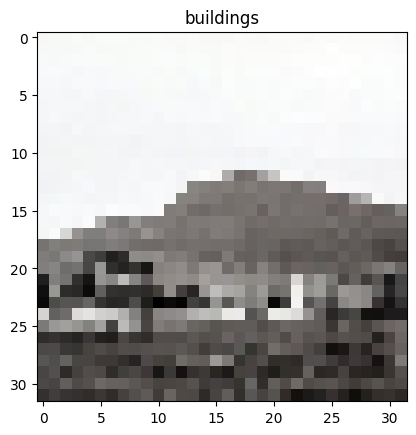

In [24]:
# Vemos una imagen
plt.imshow(X_train[0])
plt.title(y_train[0])

In [80]:
# Cogemos la función de pintado de imágenes

def show_images_batch(paisajes, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(paisajes) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, paisaje in enumerate(paisajes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje, cmap = "Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])

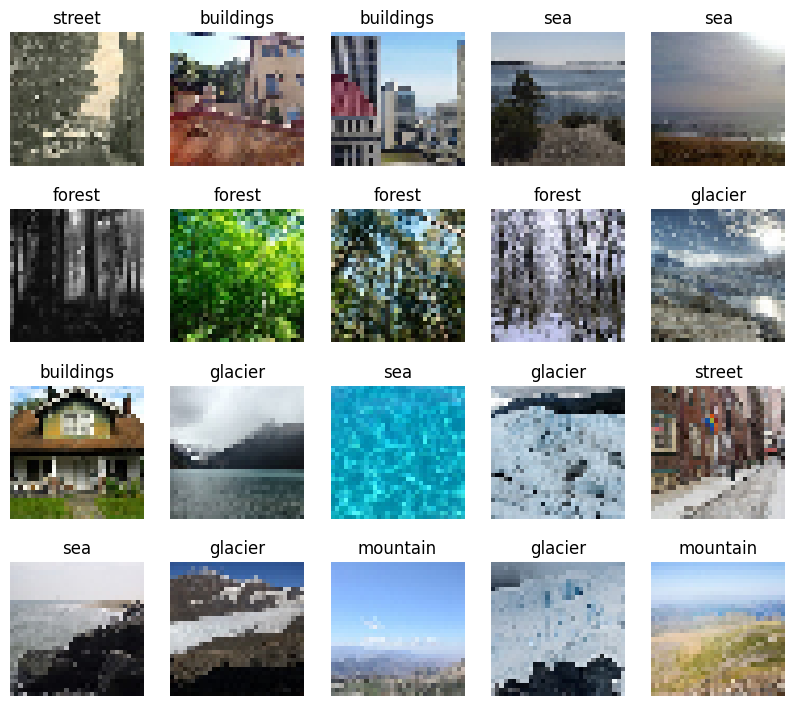

In [28]:
# Ahora vamos a pintar 20 imágenes de train aleatorias
indices = np.random.randint(0,len(X_train),20)
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

In [29]:
# Recordamos como está de balanceado el target
targets = pd.Series(y_train)
targets.value_counts(True)

mountain     0.178994
glacier      0.171298
street       0.169731
sea          0.162035
forest       0.161821
buildings    0.156121
Name: proportion, dtype: float64

In [30]:
# Finalmente normalizamos
X_train = X_train/255
X_test = X_test/255

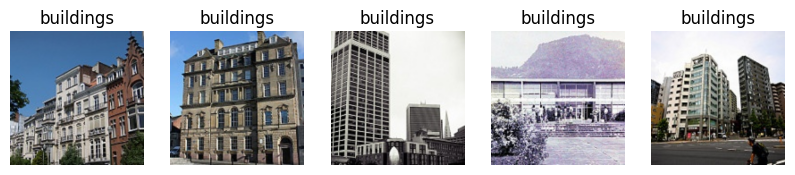

In [32]:
# Vemos la resolución de los test
show_images_batch(X_test_224[55:60],y_test_224[55:60])

In [33]:
# Barajamos los datos de train
X_train_s, y_train_s = shuffle(X_train, y_train, random_state=42)

In [34]:
# Dado que keras no permite categorias textuales hacemos el mapping

# Maopeamos las categorías a números
categorias = np.unique(y_train)
n_categorias = len(categorias)

mapping = {cat: i for i, cat in enumerate(categorias)}
inverse_mapping = {valor:clave for clave,valor in mapping.items()}

In [35]:
# Comprobamos el mapeo
mapping

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [36]:
inverse_mapping

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

In [56]:
# Mapeamos las etiquetas
y_train_num = np.array([mapping[cat] for cat in y_train_s])
y_test_num = np.array([mapping[cat] for cat in y_test])

In [57]:
# Descargamos el decodificador de predicciones para poder hacer el Zero Shot
from tensorflow.keras.applications.resnet_v2 import decode_predictions

In [61]:
# Descargamos el modelo base
base_model = ResNet50V2(include_top=True, weights='imagenet', input_shape=(224, 224, 3))

In [62]:
# Vamos a probar una predicción
seleccion = np.random.randint(0,len(X_test_224),20)
predictions = base_model.predict(X_test_224[seleccion])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


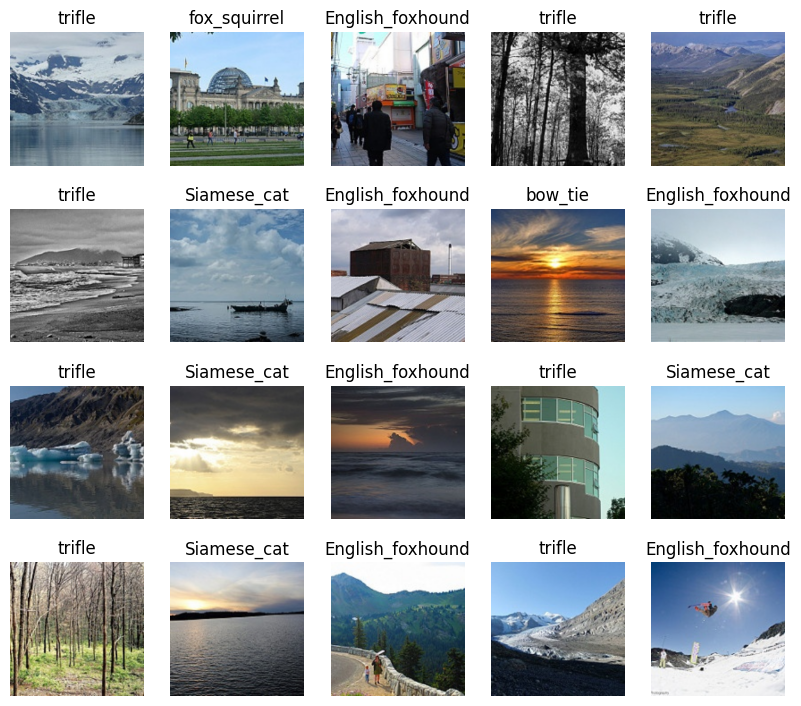

In [63]:
# Comprobamos cómo ha hecho la predicción
clase = [decodificado[0][1] for decodificado in decode_predictions(predictions)]
show_images_batch(X_test_224[seleccion], names = clase)

In [ ]:
# Como vemos las clases no coinciden y no hay ninguna clasificación bien hecha

# Pasamos a un transfer learning

# Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida.
# Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

In [64]:
# Cargamos el modelo pre-entrenado
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(32, 32, 3))

# Congelamos sus capas
for layer in base_model.layers:
    layer.trainable = False

# Capa de flatenizado de la salida del modelo base
def prepare_model(base_model = base_model): 
    x = layers.Flatten()(base_model.output)

    # Capa densa con 300 neuronas
    x = layers.Dense(300, activation='relu')(x) 
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dropout(rate = 0.5)(x)


    # Capa final de salida con 6 neuronas y activación softmax
    x = layers.Dense(6, activation='softmax')(x)

    model = Model(base_model.input, x)
    model.compile(optimizer = "adam", loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
    return model
# Observamos la arquitectura del modelo
model= prepare_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │          0 │ conv2_block1_pre… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 10, 10,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 8, 8, 256) │          0 │ conv2_block1_0_c

 Total params: 24,210,206 (92.35 MB)

 Trainable params: 645,406 (2.46 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [65]:
# Entrenamos el modelo
# Preparamos un earlyStopping
earlyS = EarlyStopping(patience= 5, restore_best_weights= True)

In [66]:
# Vemos tamaños de epoch y batch
instancias_train = len(X_train)
for i in range(1,5):
    print(f"Batch_size: {32*i}, num_steps_per_epoch: {round(instancias_train/(32*i))}")

Batch_size: 32, num_steps_per_epoch: 439
Batch_size: 64, num_steps_per_epoch: 219
Batch_size: 96, num_steps_per_epoch: 146
Batch_size: 128, num_steps_per_epoch: 110


In [67]:
# Cojo el valor de 128
batch_size = 128


In [68]:
# Entrenamos el modelo analizando lo que tarda una epoch
from time import time
t_zero = time()
model = prepare_model()
history = model.fit(X_train_s,
                    y_train_num,
                    batch_size = batch_size,
                    validation_split=0.2,
                    epochs=1,)
print(time() - t_zero)

88/88 ━━━━━━━━━━━━━━━━━━━━ 22s 215ms/step - acc: 0.3315 - loss: 1.6159 - val_acc: 0.4973 - val_loss: 1.2953
22.441988229751587


In [69]:
# 22 segundos
# Entrenamos el modelo con 20 epochs
model = prepare_model()
history = model.fit(X_train_s,
                    y_train_num,
                    batch_size = batch_size,
                    validation_split=0.2,
                    epochs=20,
                   callbacks=[earlyS])

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 23s 225ms/step - acc: 0.3370 - loss: 1.6208 - val_acc: 0.5002 - val_loss: 1.3008
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 240ms/step - acc: 0.5067 - loss: 1.2541 - val_acc: 0.5248 - val_loss: 1.2224
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 245ms/step - acc: 0.5559 - loss: 1.1430 - val_acc: 0.5390 - val_loss: 1.1908
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 239ms/step - acc: 0.6041 - loss: 1.0497 - val_acc: 0.5440 - val_loss: 1.1981
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 241ms/step - acc: 0.6280 - loss: 0.9816 - val_acc: 0.5593 - val_loss: 1.1907
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 236ms/step - acc: 0.6578 - loss: 0.9014 - val_acc: 0.5501 - val_loss: 1.2349
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 237ms/step - acc: 0.6860 - loss: 0.8243 - val_acc: 0.5379 - val_loss: 1.2801
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 239ms/step - acc: 0.7153 - loss: 0.7685 - val_acc: 0.5533 - val_loss: 1.3019
Epoch 9/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 241ms/

In [70]:
# parece que ha llegado al Patience antes de llegar a los 20 epochs
# Veamos la evolucion
evol = pd.DataFrame(history.history)

<Axes: >

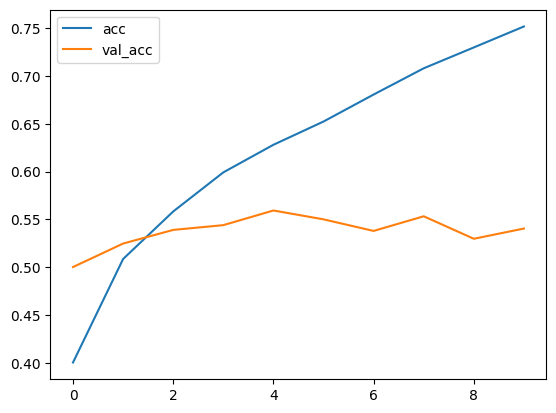

In [71]:
evol[["acc","val_acc"]].plot()

In [ ]:
# parece que a partir del epoch 3 ya no mejoramos la validation accuracy

In [72]:
# Evaluamos el modelo contra test
model.evaluate(X_test, y_test_num)

94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - acc: 0.5575 - loss: 1.2122


[1.1823070049285889, 0.5580000281333923]

In [73]:
# no ha mejorado ni empeorado sobre el valor de acc de validacion
# Veamos la matriz de confusion
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

y_pred = [inverse_mapping[np.argmax(prediccion)] for prediccion in model.predict(X_test)]
print(classification_report(y_test, y_pred))

94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step
              precision    recall  f1-score   support

   buildings       0.54      0.47      0.50       437
      forest       0.69      0.79      0.74       474
     glacier       0.51      0.47      0.49       553
    mountain       0.48      0.60      0.53       525
         sea       0.58      0.52      0.55       510
      street       0.56      0.51      0.53       501

    accuracy                           0.56      3000
   macro avg       0.56      0.56      0.56      3000
weighted avg       0.56      0.56      0.56      3000



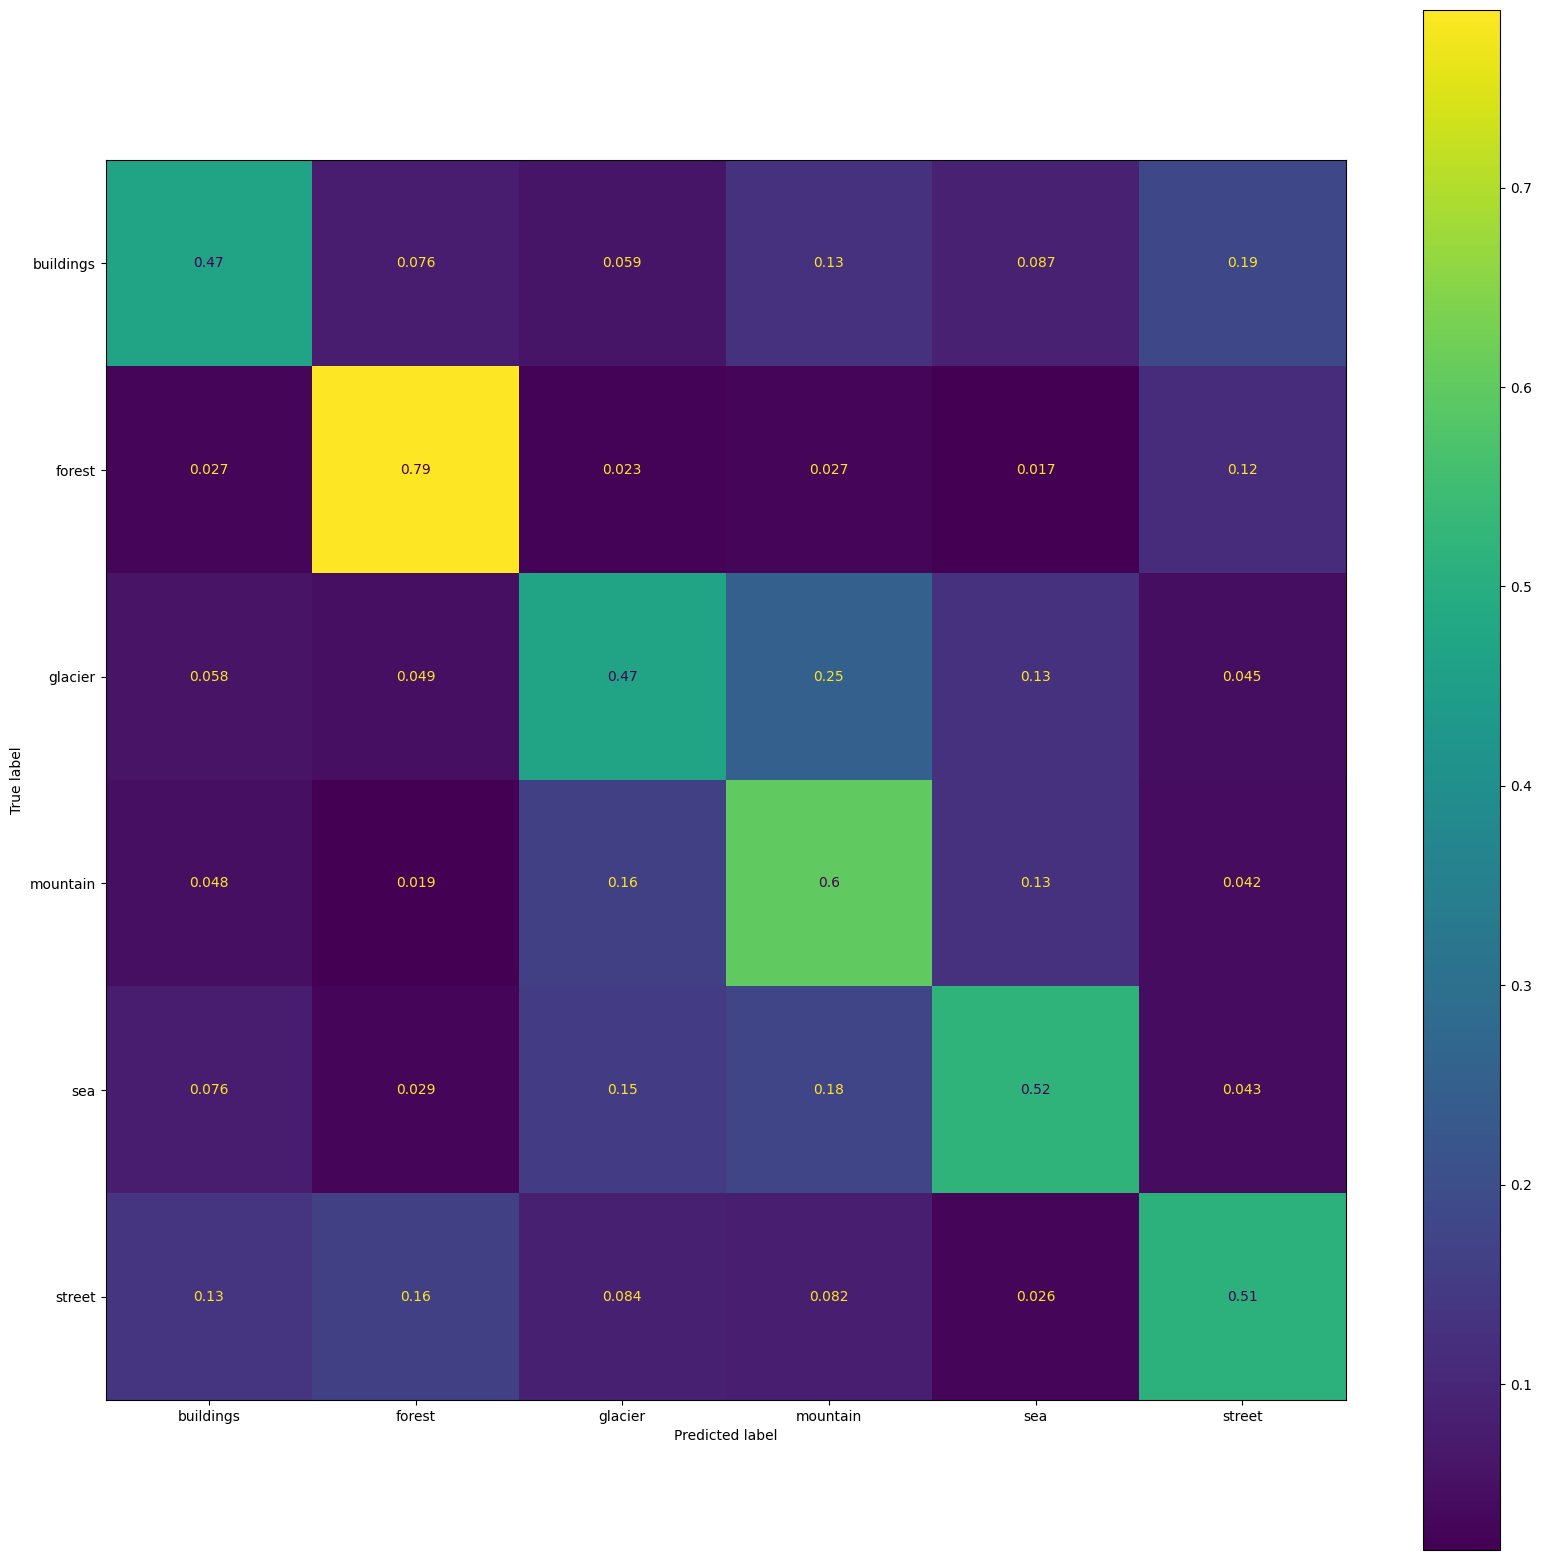

In [74]:
fig,axs = plt.subplots(1,1,figsize = (20,20))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize = "true", ax = axs)

In [75]:
# Vemos que es capaz de predecir bastante bien sobre los bosques pero no en los demas paisajes

In [84]:
# Vamos a ver alguna clasificación
resultados = pd.DataFrame({"True": y_test, "Predicted": y_pred})
errores = resultados["True"] != resultados["Predicted"]
es_building = resultados["True"] == "buildings"
predicted_mountain = resultados["Predicted"] == "mountain"
es_mountain = resultados["True"] == "mountain"

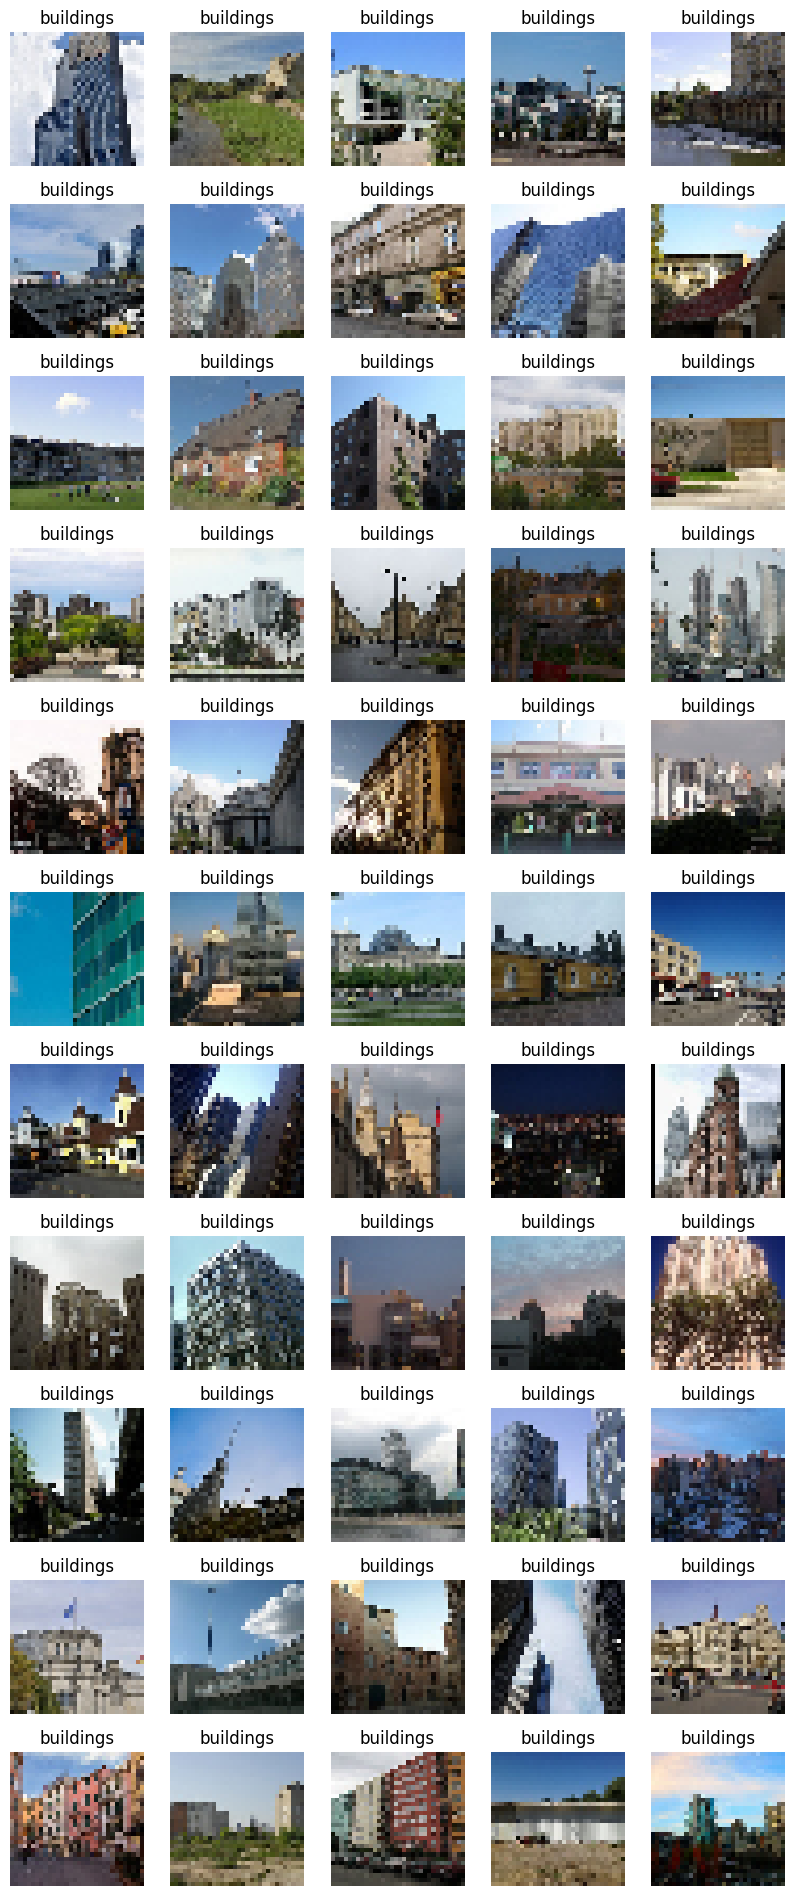

In [85]:
show_images_batch(X_test[resultados[es_building & predicted_mountain].index], y_test[resultados[es_building & predicted_mountain].index])

In [86]:
# Vemos que hay varios casos en que ha predicho que es bosque cuando es edificios

In [87]:
# Vamos a hacer ahora Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. 
# Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

# Cargamos el modelo pre-entrenado
base_model = ResNet50V2(include_top=False, weights=None, input_shape=(32, 32, 3))

# Capa de flatenizado de la salida del modelo base
def prepare_model(base_model = base_model): # Lo creamos así para poder reinicializarlo en cada reentrenamiento en ejercicios posteriores
    x = layers.Flatten()(base_model.output)

    # Capa densa con 300 neuronas
    x = layers.Dense(300, activation='relu')(x)
    x = layers.Dense(150, activation='relu')(x)
    x = layers.Dropout(rate = 0.5)(x)


    # Capa final de salida con 6 neuronas y activación softmax
    x = layers.Dense(6, activation='softmax')(x)

    model = Model(base_model.input, x)
    model.compile(optimizer = "adam", loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
    return model

# Observamos la arquitectura del modelo
model= prepare_model()
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer_7[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │          0 │ conv2_block1_pre… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 10, 10,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 8, 8, 256) │          0 │ conv2_block1_0_c

 Total params: 24,225,556 (92.41 MB)

 Trainable params: 24,180,116 (92.24 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [88]:
# Entrenamos con un early stop con un patience de 10 epochs
earlySFT = EarlyStopping(restore_best_weights= True, patience= 10)

In [89]:
# Vamos a hacer un entrenamiento de 50 epochs

model = prepare_model()
history = model.fit(X_train_s,
                    y_train_num,
                    batch_size = batch_size,
                    validation_split=0.2,
                    epochs=50,
                   callbacks= earlySFT)


Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 95s 905ms/step - acc: 0.3811 - loss: 1.5670 - val_acc: 0.1699 - val_loss: 1.9629
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 79s 900ms/step - acc: 0.6295 - loss: 1.0288 - val_acc: 0.2191 - val_loss: 2.7961
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 81s 916ms/step - acc: 0.7046 - loss: 0.8450 - val_acc: 0.4311 - val_loss: 1.4105
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 82s 927ms/step - acc: 0.7606 - loss: 0.7197 - val_acc: 0.4592 - val_loss: 1.7315
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 85s 972ms/step - acc: 0.7826 - loss: 0.6404 - val_acc: 0.6152 - val_loss: 1.1778
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 83s 946ms/step - acc: 0.7711 - loss: 0.6661 - val_acc: 0.5714 - val_loss: 1.2523
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 81s 923ms/step - acc: 0.8133 - loss: 0.5514 - val_acc: 0.6605 - val_loss: 0.9906
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 81s 927ms/step - acc: 0.8401 - loss: 0.4920 - val_acc: 0.5967 - val_loss: 1.4069
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 84s 956ms/

<Axes: >

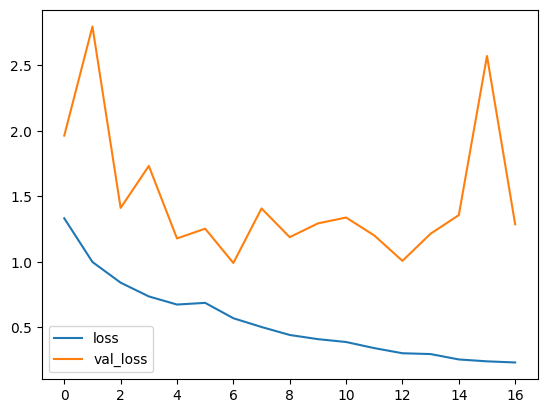

In [90]:
# No ha conseguido bajar del patience y se ha detenido en el epoch 17
# Vemos la evolucion

df_evol = pd.DataFrame(history.history)
df_evol[["loss","val_loss"]].plot()

In [91]:
# El mejor resultado lo hemos obtenido en el epoch 6
# Vamos a ver la evaluacion con test

model.evaluate(X_test, y_test_num)

94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - acc: 0.6705 - loss: 1.0415


[1.0489059686660767, 0.656333327293396]

In [92]:
# Un 65,6% de accuracy. No parece un valor espectacular. habría que reentrenar la red con otros parámetros
# Vemos la matriz de confusión
y_pred = [inverse_mapping[np.argmax(prediccion)] for prediccion in model.predict(X_test)]
print(classification_report(y_test, y_pred))

94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step
              precision    recall  f1-score   support

   buildings       0.61      0.58      0.60       437
      forest       0.78      0.91      0.84       474
     glacier       0.61      0.55      0.58       553
    mountain       0.67      0.71      0.69       525
         sea       0.55      0.75      0.63       510
      street       0.82      0.45      0.58       501

    accuracy                           0.66      3000
   macro avg       0.67      0.66      0.65      3000
weighted avg       0.67      0.66      0.65      3000



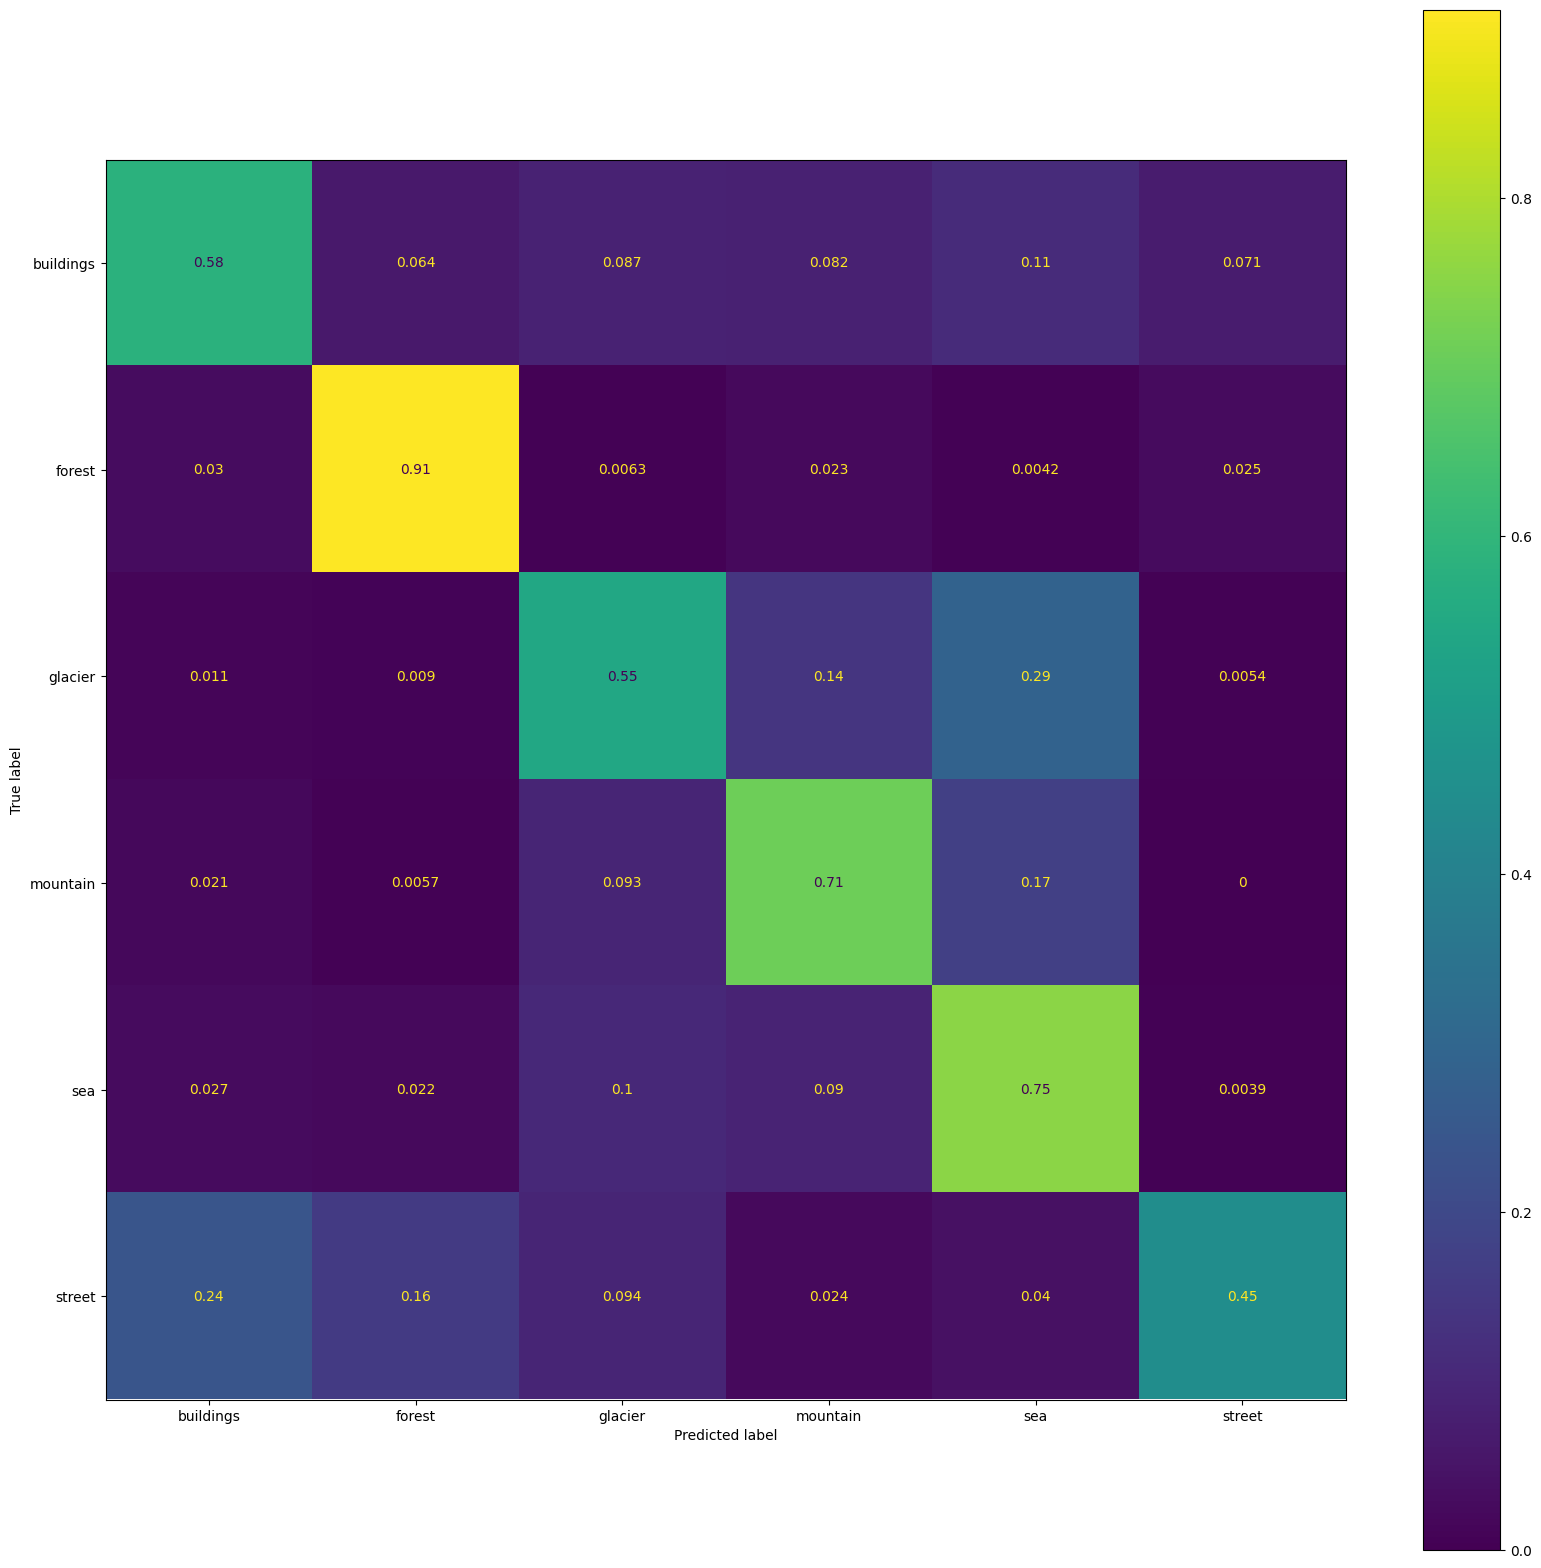

In [93]:
# Vemos que tiene un comporatmiento bastante bueno en el forest. Los demás caen bastante en comportamiento
fig,axs = plt.subplots(1,1,figsize = (20,20))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize = "true", ax = axs)

In [125]:
# Ahí tenemos el resultado: forest, mountain y sea son los paisajes mejor clasificados
# Vamos a hacer una prueba con fotos de internet

# Cargamos los datos de test

ROOT_PATH = './data/prueba/'

def read_data(reshape_dim = (32,32)):
    X = []
    y = []
    
    for file in os.listdir(ROOT_PATH):

        image = plt.imread('/'.join([ROOT_PATH, file]))
        image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32

        X.append(image)
        y.append(str(file).split('.')[0])

    return np.array(X),np.array(y)

In [126]:
X_final,y_final = read_data()
X_final.shape

(7, 32, 32, 3)

In [129]:
# hemos mejorado el accuracy un poco sobre la red convolucional del ejercicio, sin embargo tampoco ha sido algo espectacular.
# Hemos pasado de un 60% a un 66%. Para la complejidad del modelo que hemos utilizado tampoco es una mejora significativa